In [1]:
!ls logs_test

BipedalWalker-A2C.monitor.csv
BipedalWalker-ACKTR.monitor.csv
BipedalWalker-DPDQN1.monitor.csv
BipedalWalker-DPDQN2.monitor.csv
BipedalWalker-PPO2.monitor.csv
BipedalWalker-SAC.monitor.csv
BipedalWalker-TD3.monitor.csv
CarRacing-A2C.monitor.csv
CarRacing-DPDQN1.monitor.csv
CarRacing-PPO2.monitor.csv
LunarLanderContinuous-A2C.monitor.csv
LunarLanderContinuous-ACKTR.monitor.csv
LunarLanderContinuous-DPDQN1.monitor.csv
LunarLanderContinuous-DPDQN1_greedy.monitor.csv
LunarLanderContinuous-DPDQN2.monitor.csv
LunarLanderContinuous-PPO2.monitor.csv
LunarLanderContinuous-SAC.monitor.csv
LunarLanderContinuous-TD3.monitor.csv
LunarLanderContinuous.monitor.csv
Pendulum-A2C.monitor.csv
Pendulum-ACKTR.monitor.csv
Pendulum-DPDQN1.monitor.csv
Pendulum-DPDQN2.monitor.csv
Pendulum-PPO2.monitor.csv
Pendulum-SAC.monitor.csv
Pendulum-TD3.monitor.csv


In [2]:
!head logs_test/Pendulum-TD3.monitor.csv 

#{"t_start": 1573434310.911062, "env_id": "Pendulum-v0"}











In [3]:
import csv
import json
import os
import time
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 300

import pandas
import pandas as pd
from gym.core import Wrapper

class LoadMonitorResultsError(Exception):
    """
    Raised when loading the monitor log fails.
    """
    pass

def load_result(path):
    """
    Load results from a given file
    :param path: (str) the path to the log file
    :return: (Pandas DataFrame) the logged data
    """
    # get both csv and (old) json files
    monitor_files = glob(path)
    if not monitor_files:
        raise LoadMonitorResultsError("no monitor files of the form *%s found in %s" % (Monitor.EXT, path))
    data_frames = []
    headers = []
    for file_name in monitor_files:
        with open(file_name, 'rt') as file_handler:
            if file_name.endswith('csv'):
                first_line = file_handler.readline()
                assert first_line[0] == '#'
                header = json.loads(first_line[1:])
                data_frame = pandas.read_csv(file_handler, index_col=None)
                headers.append(header)
            elif file_name.endswith('json'):  # Deprecated json format
                episodes = []
                lines = file_handler.readlines()
                header = json.loads(lines[0])
                headers.append(header)
                for line in lines[1:]:
                    episode = json.loads(line)
                    episodes.append(episode)
                data_frame = pandas.DataFrame(episodes)
            else:
                assert 0, 'unreachable'
            data_frame['t'] += header['t_start']
        data_frames.append(data_frame)
    data_frame = pandas.concat(data_frames)
    data_frame.sort_values('t', inplace=True)
    data_frame.reset_index(inplace=True)
    data_frame['t'] -= min(header['t_start'] for header in headers)
    # data_frame.headers = headers  # HACK to preserve backwards compatibility
    data_frame["lc"]=data_frame["l"].cumsum()
    data_frame.set_index('index')
    
    data_frame["reward_moving"]=data_frame["r"].rolling(25).mean()
    return data_frame

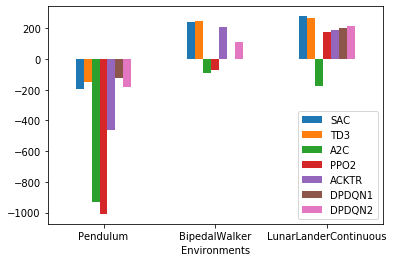

In [4]:
def getMean(alg,env):
    df = load_result('logs_test/'+env+'-'+alg+'.monitor.csv') 
    return df["r"].mean()

algs=['SAC','TD3','A2C','PPO2','ACKTR','DPDQN1','DPDQN2']

def makeFinalPerformanceDF():

    
    envs=['Pendulum','BipedalWalker','LunarLanderContinuous']
    
    vals=dict()
    for env in envs:
        for alg in algs:
            vals[alg]=list()

    for env in envs:
        for alg in algs:
            vals[alg].append(getMean(alg,env))
    

    df = pd.DataFrame({'Environments':envs, 'SAC':vals["SAC"], 'TD3':vals["TD3"], 'A2C':vals["A2C"], 'PPO2':vals["PPO2"], 'ACKTR':vals["ACKTR"], 'DPDQN1':vals["DPDQN1"], 'DPDQN2':vals["DPDQN2"]  })
    
    return df

df = makeFinalPerformanceDF()
ax = df.plot.bar(x='Environments', rot=0)


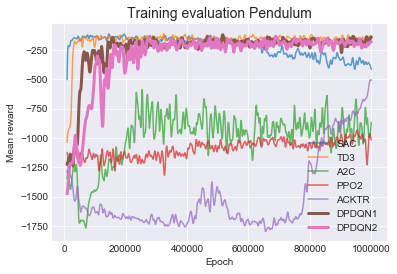

In [6]:
from scipy.ndimage.filters import gaussian_filter1d

def plotTrainingDF(env):
    
    # style
    plt.style.use('seaborn-darkgrid')

    # create a color palette
    palette = plt.get_cmap('Set1')
    
    for alg in algs:
        df = load_result('logs_train/'+env+'-'+alg+'.monitor.csv') 
        if "DPDQN" in alg:
            plt.plot(df['lc'], gaussian_filter1d(df["reward_moving"],sigma=6), marker='', alpha=1, linewidth=3, label=alg)
        else:
            plt.plot(df['lc'], gaussian_filter1d(df["reward_moving"],sigma=6), marker='', alpha=0.7, label=alg)

    plt.legend()

    plt.title("Training evaluation "+env, fontsize=14, fontweight=0)
    plt.xlabel("Epoch")
    plt.ylabel("Mean reward")
    
    return df

envs=['Pendulum']
for env in envs:
    df = plotTrainingDF(env)


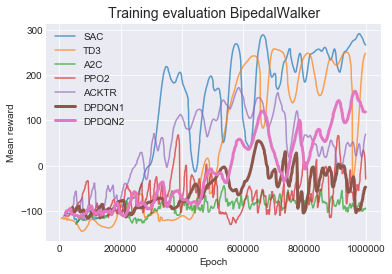

In [7]:

envs=['BipedalWalker']
for env in envs:
    df = plotTrainingDF(env)


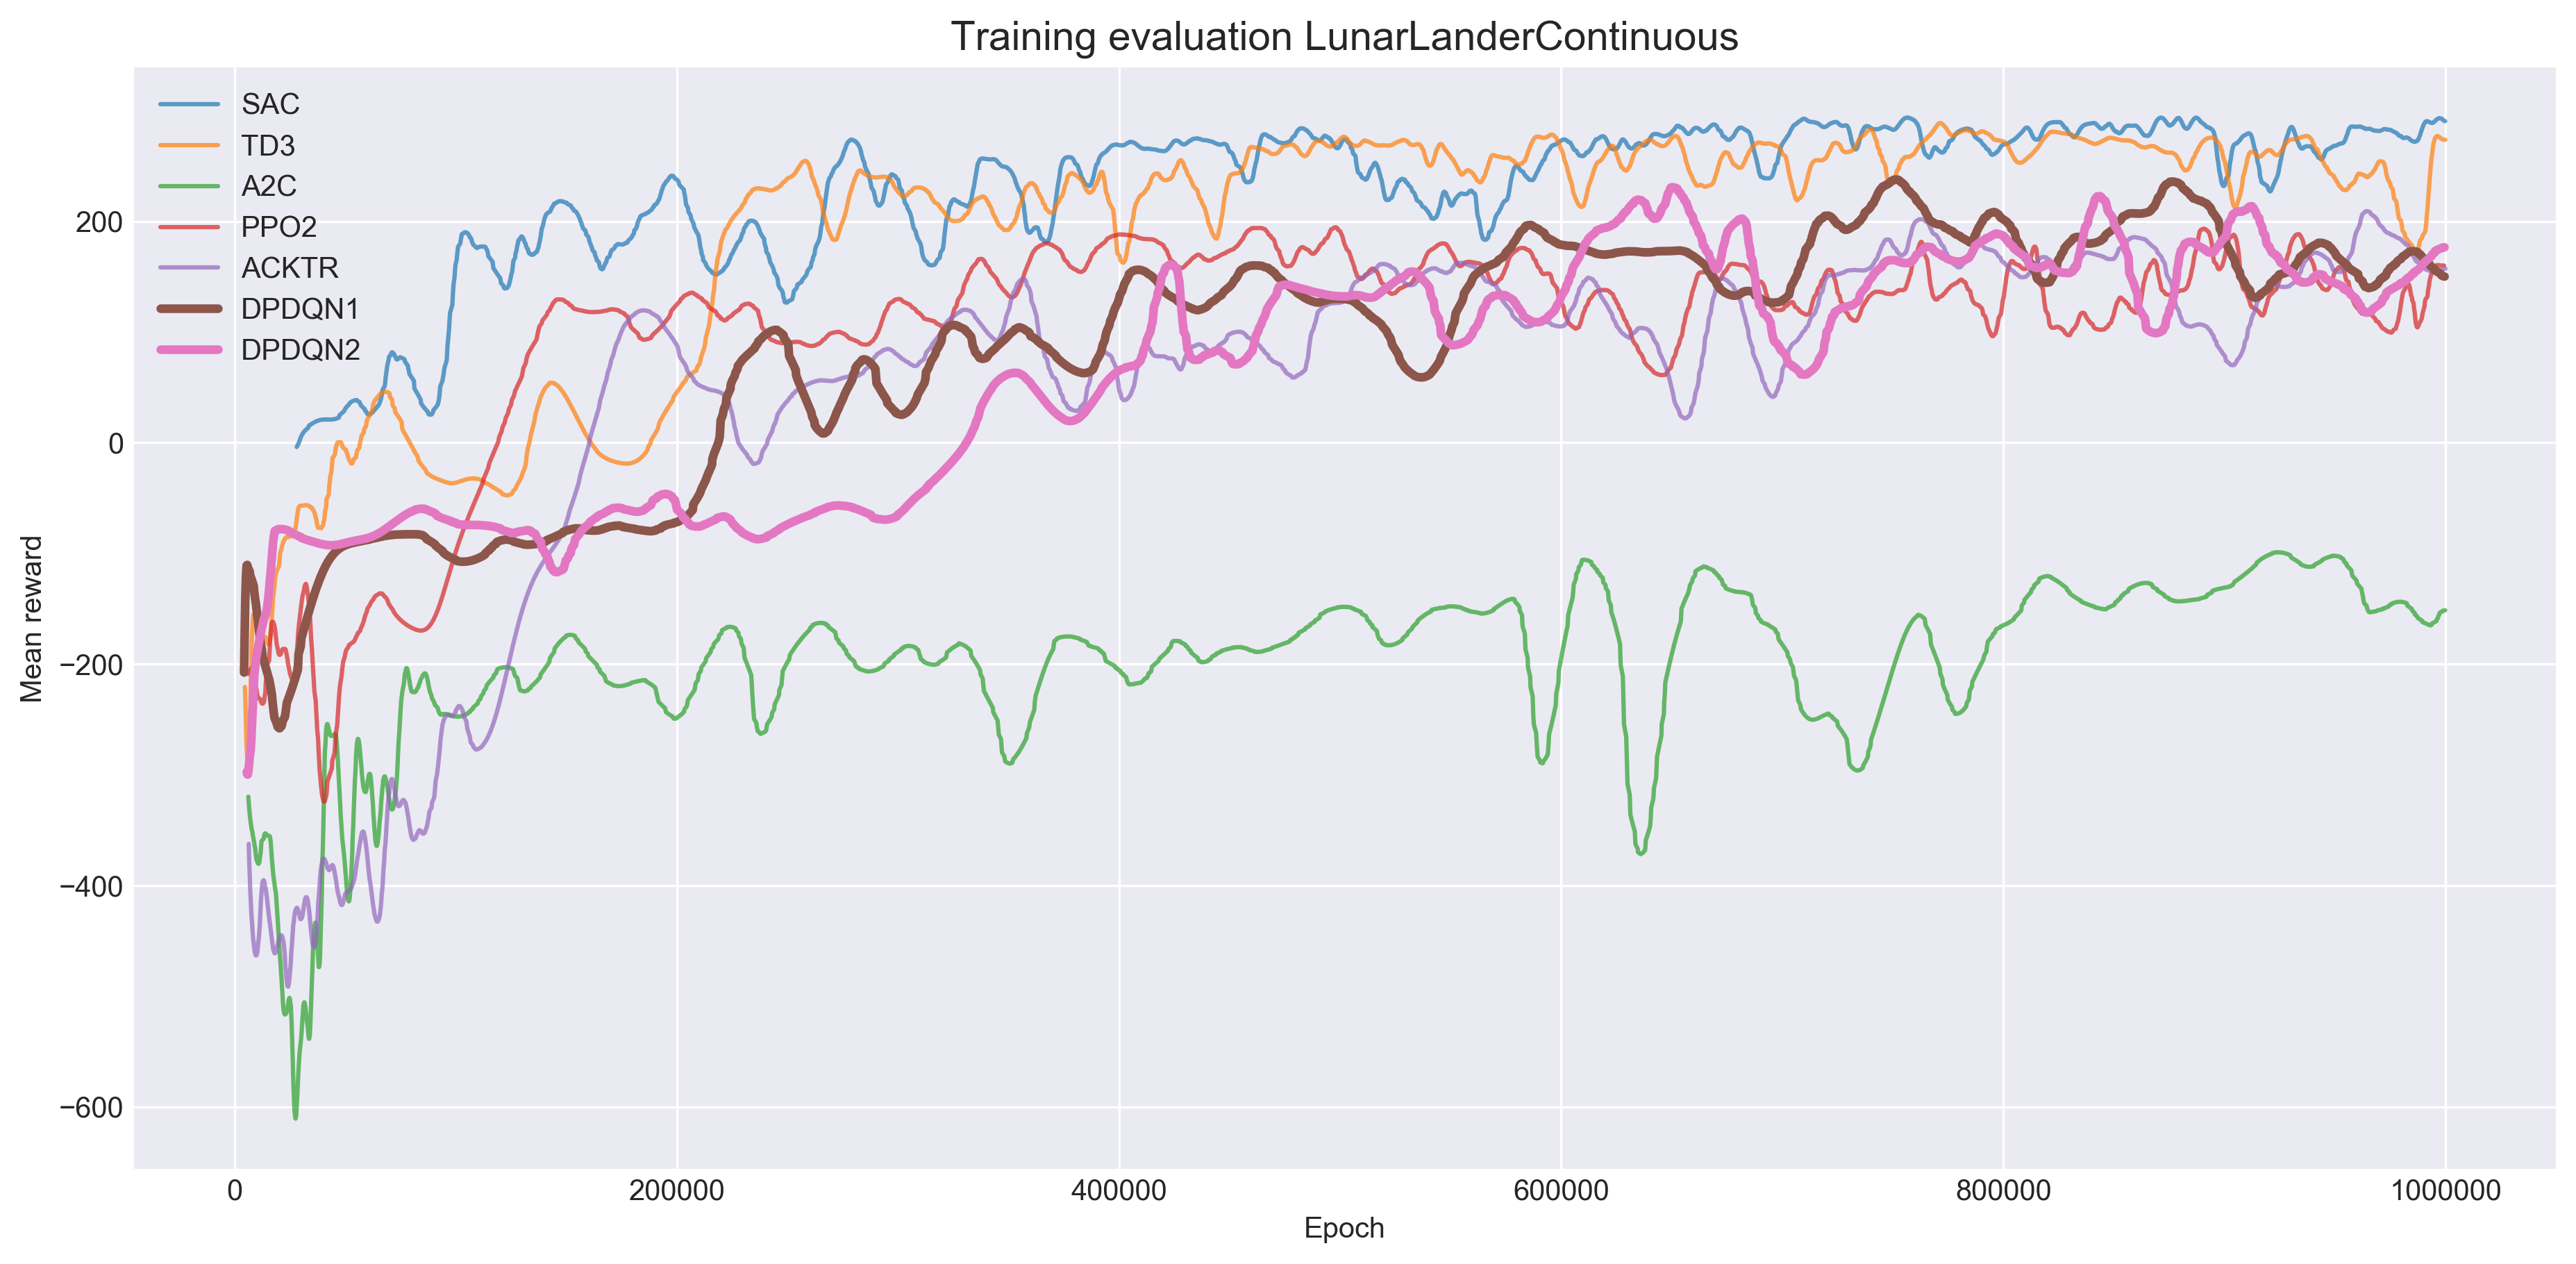

In [31]:

envs=['LunarLanderContinuous']
for env in envs:
    df = plotTrainingDF(env)


In [1]:
#Policy performance analysis TODO change to v2

In [8]:
from dpdqn_v2 import DPDQN2
import time



import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import gym
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
time_steps = 1e6 #testrun
#time_steps = 100000 #for prod or even more *10?100?
time_steps_test = int(time_steps/100)

from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import results_plotter

os.makedirs("logs_test", exist_ok=True)
os.makedirs("logs_train", exist_ok=True)
os.makedirs("logs_tmp", exist_ok=True)
from shutil import copyfile
from utils import *

#render video
#render
envname="BipedalWalker-v2"

env = gym.make(envname)
exp_name=env.spec._env_name+'-DPDQN2'
log_dir='logs_test/'+exp_name


obs = env.reset()


print("Not greedy with 30 samples")
model = DPDQN2.load("models/"+log_dir.split("/")[1], env)
start = time.time()
for i in range(1000):
    action, _states = model.predict(obs, greedy=False, num_action_samples=30)
end = time.time()
print((end - start)/1000)

print("Not greedy with 300 samples")
model = DPDQN2.load("models/"+log_dir.split("/")[1], env)
start = time.time()
for i in range(1000):
    action, _states = model.predict(obs, greedy=False, num_action_samples=300)
end = time.time()
print((end - start)/1000)



print("Greedy with 10 steps")
model = DPDQN2.load("models/"+log_dir.split("/")[1], env)
model.agent.greedy_opt_steps=10
start = time.time()
for i in range(1000):
    action, _states = model.predict(obs, greedy=True, num_action_samples=30)
end = time.time()
print((end - start)/1000)

print("Greedy with 100 steps")
model = DPDQN2.load("models/"+log_dir.split("/")[1], env)
model.agent.greedy_opt_steps=100
start = time.time()
for i in range(1000):
    action, _states = model.predict(obs, greedy=True, num_action_samples=30)
end = time.time()
print((end - start)/1000)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Not greedy with 30 samples
0.0016311628818511963
Not greedy with 300 samples
0.012323004722595215
Greedy with 10 steps
0.00721209716796875
Greedy with 100 steps
0.03227504301071167


In [9]:
%%time
model.agent.greedy_opt_steps=0
print(model.evaluate(n_games=10))
model.agent.greedy_lr=0.0005
model.agent.greedy_opt_steps=5
print(model.evaluate(n_games=10))

192.75805604355128
123.19158302782357
CPU times: user 10min 34s, sys: 4.88 s, total: 10min 39s
Wall time: 1min 47s


In [10]:
%%time
model.agent.greedy_opt_steps=0
print(model.evaluate(n_games=10), num_action_samples=30)
model.agent.greedy_opt_steps=0
print(model.evaluate(n_games=10), num_action_samples=100)

TypeError: 'num_action_samples' is an invalid keyword argument for this function